# Penyeimbangan data Ecoli

**Apa itu Penyeimbangan Data?**

Penyeimbangan data adalah proses mengatasi ketidakseimbangan distribusi kelas (class imbalance) pada dataset.
Masalah ini terjadi ketika satu kelas jauh lebih banyak dibanding kelas lain, sehingga model cenderung bias ke kelas mayoritas dan mengabaikan kelas minoritas.

Contoh:
- Dataset fraud: 99% transaksi normal, 1% transaksi fraud.
- Jika model hanya menebak “normal” terus, akurasinya 99%, tapi tidak berguna.

**Mengapa Perlu Penyeimbangan Data?**

Model machine learning biasanya mengasumsikan distribusi kelas relatif seimbang.
Jika tidak, akibatnya:

- Model tidak mengenali pola penting pada kelas minoritas.
- Prediksi kelas minoritas menjadi buruk.

Karena itu, dataset perlu diseimbangkan agar model:
- Lebih adil (fair).
- Bisa mempelajari pola minoritas lebih baik.
- Mengurangi bias pada prediksi.

In [126]:
# IMPORT LIBRARY
from sklearn.decomposition import PCA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

In [3]:
fitur = ["mcg", "gvh", "lip", "chg", "aac", "alm1", "alm2"]

def remove_empty(data):

    hasil = []

    for kal in range(len(data)):
        a = np.array(data[kal].split(" "))
        hasil.append(a[a != ''])

    return pd.DataFrame(hasil, columns=["name", "mcg", "gvh", "lip", "chg", "aac", "alm1", "alm2", "class"])


In [4]:
ecoli_df = 0

with open("ecoli.data") as file:
    a = np.array(file.read().splitlines())
    ecoli_df = remove_empty(a)

ecoli_df

,name,mcg,gvh,lip,chg,aac,alm1,alm2,class
0,AAT_ECOLI,0.49,0.29,0.48,0.50,0.56,0.24,0.35,cp
1,ACEA_ECOLI,0.07,0.40,0.48,0.50,0.54,0.35,0.44,cp
2,ACEK_ECOLI,0.56,0.40,0.48,0.50,0.49,0.37,0.46,cp
3,ACKA_ECOLI,0.59,0.49,0.48,0.50,0.52,0.45,0.36,cp
4,ADI_ECOLI,0.23,0.32,0.48,0.50,0.55,0.25,0.35,cp
...,...,...,...,...,...,...,...,...,...
331,TREA_ECOLI,0.74,0.56,0.48,0.50,0.47,0.68,0.30,pp
332,UGPB_ECOLI,0.71,0.57,0.48,0.50,0.48,0.35,0.32,pp
333,USHA_ECOLI,0.61,0.60,0.48,0.50,0.44,0.39,0.38,pp
334,XYLF_ECOLI,0.59,0.61,0.48,0.50,0.42,0.42,0.37,pp


## Menyimpan data ke database mysql

In [ ]:
import mysql.connector as myconnector

conn = myconnector.connect(
    host="localhost",
    port=3306,
    user="root",
    password="",
    database="imbalance"
)

cursor = conn.cursor()

cursor.execute('''DROP TABLE IF EXISTS ecoli_data''')
cursor.execute('''
    CREATE TABLE ecoli_data (
        id INT PRIMARY KEY AUTO_INCREMENT,
        name VARCHAR(50),
        mcg DECIMAL(5, 2),
        gvh DECIMAL(5, 2),
        lip DECIMAL(5, 2),
        chg DECIMAL(5, 2),
        aac DECIMAL(5, 2),
        alm1 DECIMAL(5, 2),
        alm2 DECIMAL(5, 2),
        class VARCHAR(3)
    )
''')

conn.commit()

In [8]:
for data_index in range(ecoli_df.shape[0]):
    data = ecoli_df.iloc[data_index]
    values = f"VALUES('{data['name']}', {data['mcg']}, {data['gvh']}, {data['lip']}, {data['chg']}, {data['aac']}, {data['alm1']}, {data['alm2']}, '{data['class']}')"
    cursor.execute(f"INSERT INTO ecoli_data(name, mcg, gvh, lip, chg, aac, alm1, alm2, class) {values}")

conn.commit()
cursor.close()
conn.close()

## Distribusi Kelas Pada Data Ecoli

Text(0.5, 1.0, 'Distribusi Kelas di Data Ecoli')

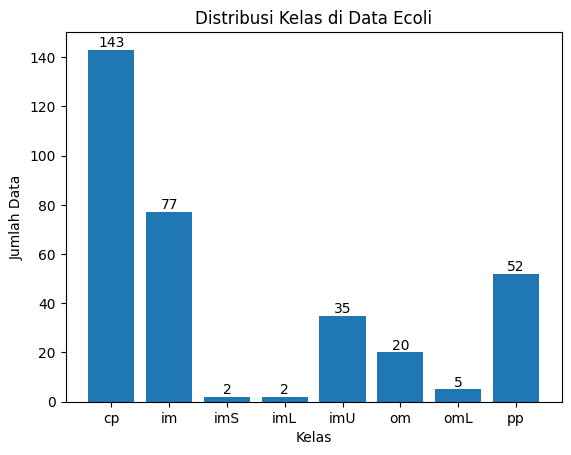

In [5]:
class_ecoli = ecoli_df["class"].unique()
distributed_data = []

for clas in class_ecoli:
    distributed_data.append(len(ecoli_df[ecoli_df["class"]  == clas]))

plt.bar(class_ecoli, distributed_data)

for i, v in enumerate(distributed_data):
    plt.text(i, v + 1.2, str(v), ha='center')

plt.xlabel("Kelas")
plt.ylabel("Jumlah Data")
plt.title("Distribusi Kelas di Data Ecoli")

## Scatter Plot dari Data Ecoli

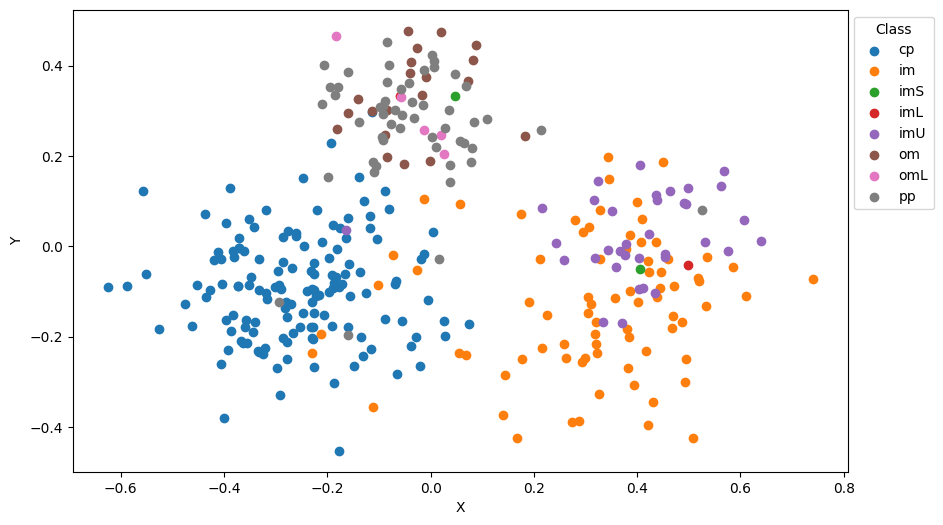

In [ ]:
pca = PCA(n_components=2)

reduced = pd.DataFrame(pca.fit_transform(ecoli_df[fitur]))

# merge = np.hstack((reduced, ecoli_df["class"]))


reduced = reduced.merge(ecoli_df["class"], left_index=True, right_index=True)

plt.figure(figsize=(10, 6))
for i in reduced['class'].unique():
    plt.scatter(reduced[reduced["class"] == i][0], reduced[reduced["class"] == i][1], label=i)

plt.xlabel("X")
plt.ylabel("Y")

plt.legend(title="Class", bbox_to_anchor=(1.12,1), loc="upper right")

plt.show()

## Penyeimbangan Data menggunakan ADASYN

ADASYN (Adaptive Synthetic Sampling) adalah pengembangan dari SMOTE.
Kalau SMOTE menambah data sintetis secara merata untuk semua sampel minoritas,
ADASYN menyesuaikan jumlah data sintetis per-sampel minoritas berdasarkan tingkat kesulitan sampel tersebut dipelajari (learning difficulty).

Intinya:
- Sampel minoritas yang lingkungannya lebih banyak mayoritas → dibuat lebih banyak titik sintetis.
- Sampel minoritas yang lingkungannya relatif aman → dibuat lebih sedikit titik sintetis.
- Ini membuat model lebih fokus pada area minoritas yang sulit diklasifikasikan.

In [128]:
from imblearn.over_sampling import ADASYN

X = ecoli_df[fitur]
y = ecoli_df["class"]

n_neigbors = [1, 4, 19, 34, 51, 76]

adasyn = ADASYN(n_neighbors=1, sampling_strategy="minority")
x_resampled, y_resampled = adasyn.fit_resample(X, y)

for n in n_neigbors:
    x_resampled, y_resampled = ADASYN(n_neighbors=n, sampling_strategy="minority").fit_resample(x_resampled, y_resampled)

merge = x_resampled.merge(y_resampled, left_index=True, right_index=True)

n_original = len(X)
n_total = len(x_resampled)

idx_original = range(n_original)
idx_sintetis = range(n_original, n_total)

merge


,mcg,gvh,lip,chg,aac,alm1,alm2,class
0,0.49,0.29,0.48,0.5,0.56,0.24,0.35,cp
1,0.07,0.4,0.48,0.5,0.54,0.35,0.44,cp
2,0.56,0.4,0.48,0.5,0.49,0.37,0.46,cp
3,0.59,0.49,0.48,0.5,0.52,0.45,0.36,cp
4,0.23,0.32,0.48,0.5,0.55,0.25,0.35,cp
...,...,...,...,...,...,...,...,...
1148,0.244212,0.533891,0.48,0.5,0.359839,0.738971,0.579936,im
1149,0.349386,0.501769,0.48,0.5,0.424939,0.642924,0.420664,im
1150,0.600024,0.460024,0.48,0.5,0.448942,0.809976,0.828801,im
1151,0.379442,0.654549,0.48,0.5,0.524664,0.706137,0.572504,im


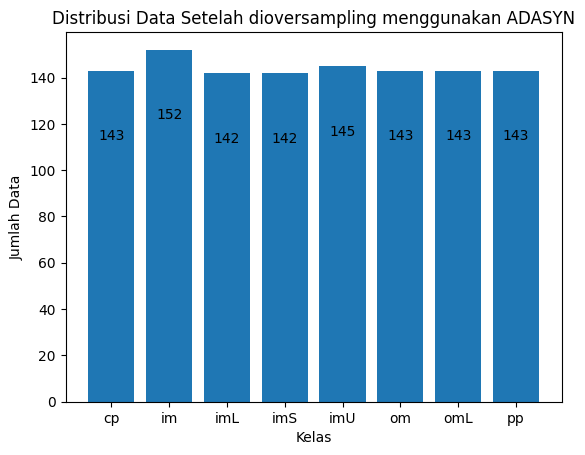

In [148]:
bar = np.array(sorted(Counter(y_resampled).items()))
kelas, dist_data = np.hsplit(bar, 2)
kelas = kelas.ravel().tolist()
dist_data = dist_data.astype(int).ravel().tolist()

plt.bar(kelas, dist_data)
plt.xlabel("Kelas")
plt.ylabel("Jumlah Data")
plt.title("Distribusi Data Setelah dioversampling menggunakan ADASYN")

for i, v in enumerate(dist_data):
    plt.text(i, v - 30, str(v), ha="center")
plt.show()

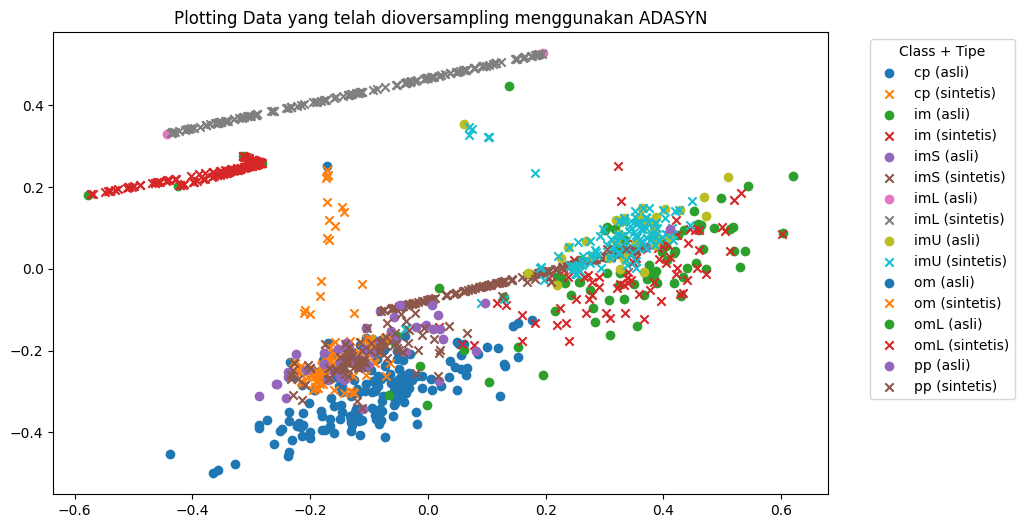

In [136]:
n_asli = len(X)

# Buat dataframe PCA + label
pca = PCA(n_components=2)
pca_data = pd.DataFrame(pca.fit_transform(x_resampled), columns=['PC1','PC2'])
pca_data['class'] = y_resampled.values

# Tambah kolom tipe: Asli atau Sintetis
pca_data['tipe'] = 'Asli'
pca_data.loc[n_asli:, 'tipe'] = 'Sintetis'   # baris setelah n_asli adalah sintetis

plt.figure(figsize=(10,6))

# Scatter tiap kelas dan tipe berbeda marker
for kelas in pca_data['class'].unique():
    asli = pca_data[(pca_data['class']==kelas) & (pca_data['tipe']=='Asli')]
    sintetis = pca_data[(pca_data['class']==kelas) & (pca_data['tipe']=='Sintetis')]

    plt.scatter(asli['PC1'], asli['PC2'], label=f"{kelas} (asli)", marker='o')
    plt.scatter(sintetis['PC1'], sintetis['PC2'], label=f"{kelas} (sintetis)", marker='x')

plt.title("Plotting Data yang telah dioversampling menggunakan ADASYN")
plt.legend(title="Class + Tipe", bbox_to_anchor=(1.25,1), loc="upper right")
plt.show()

## Penyeimbangan data menggunakan SMOTE

SMOTE (Synthetic Minority Over-sampling Technique) adalah teknik untuk menangani masalah class imbalance (ketidakseimbangan jumlah data antar kelas) pada pembelajaran mesin.
Alih-alih hanya menggandakan data minoritas, SMOTE membuat data sintetis baru dengan cara interpolasi antar titik minoritas yang ada.

Prinsip utamanya:
- Pilih satu sampel minoritas. 
- Cari 𝑘
- k-nearest neighbor (sama-sama minoritas).
- Pilih salah satu tetangga secara acak.
- Buat titik baru di antara keduanya dengan interpolasi linier.

In [108]:
from imblearn.over_sampling import SMOTE

p = ecoli_df[fitur]
q = ecoli_df["class"]

p_resampled, q_resampled = SMOTE(random_state=42, k_neighbors=1).fit_resample(X, y)

<BarContainer object of 8 artists>

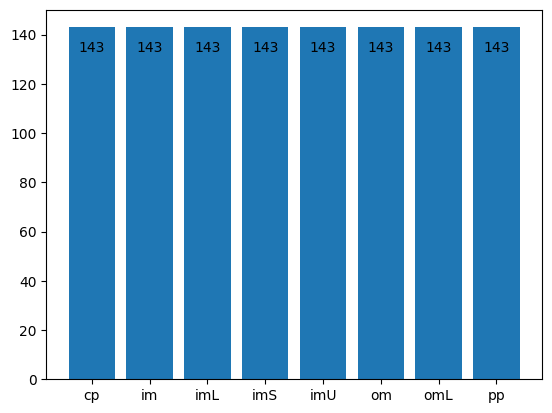

In [121]:
bar_smote = np.array(sorted(Counter(q_resampled).items()))
kelas_smote, dist_smote = np.hsplit(bar_smote, 2)
kelas_smote = kelas_smote.ravel().tolist()
dist_smote = dist_smote.astype(int).ravel().tolist()

for i, v in enumerate(dist_smote):
    plt.text(i, v - 10, str(v), ha="center")

plt.bar(kelas_smote, dist_smote)

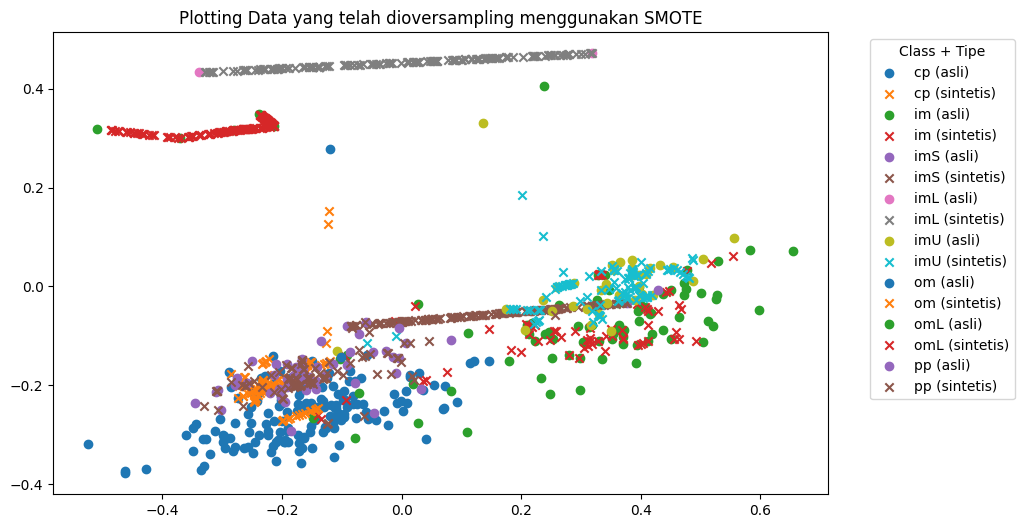

In [138]:
n_asli = len(p)

# Buat dataframe PCA + label
pca = PCA(n_components=2)
pca_data = pd.DataFrame(pca.fit_transform(p_resampled), columns=['PC1','PC2'])
pca_data['class'] = q_resampled.values

# Tambah kolom tipe: Asli atau Sintetis
pca_data['tipe'] = 'Asli'
pca_data.loc[n_asli:, 'tipe'] = 'Sintetis'   # baris setelah n_asli adalah sintetis

plt.figure(figsize=(10,6))

# Scatter tiap kelas dan tipe berbeda marker
for kelas in pca_data['class'].unique():
    asli = pca_data[(pca_data['class']==kelas) & (pca_data['tipe']=='Asli')]
    sintetis = pca_data[(pca_data['class']==kelas) & (pca_data['tipe']=='Sintetis')]

    plt.scatter(asli['PC1'], asli['PC2'], label=f"{kelas} (asli)", marker='o')
    plt.scatter(sintetis['PC1'], sintetis['PC2'], label=f"{kelas} (sintetis)", marker='x')

plt.title("Plotting Data yang telah dioversampling menggunakan SMOTE")
plt.legend(title="Class + Tipe", bbox_to_anchor=(1.25,1), loc="upper right")
plt.show()

## Perbandingan

### Perbandingan Distribusi kelas Data Asli, ADASYN, SMOTE

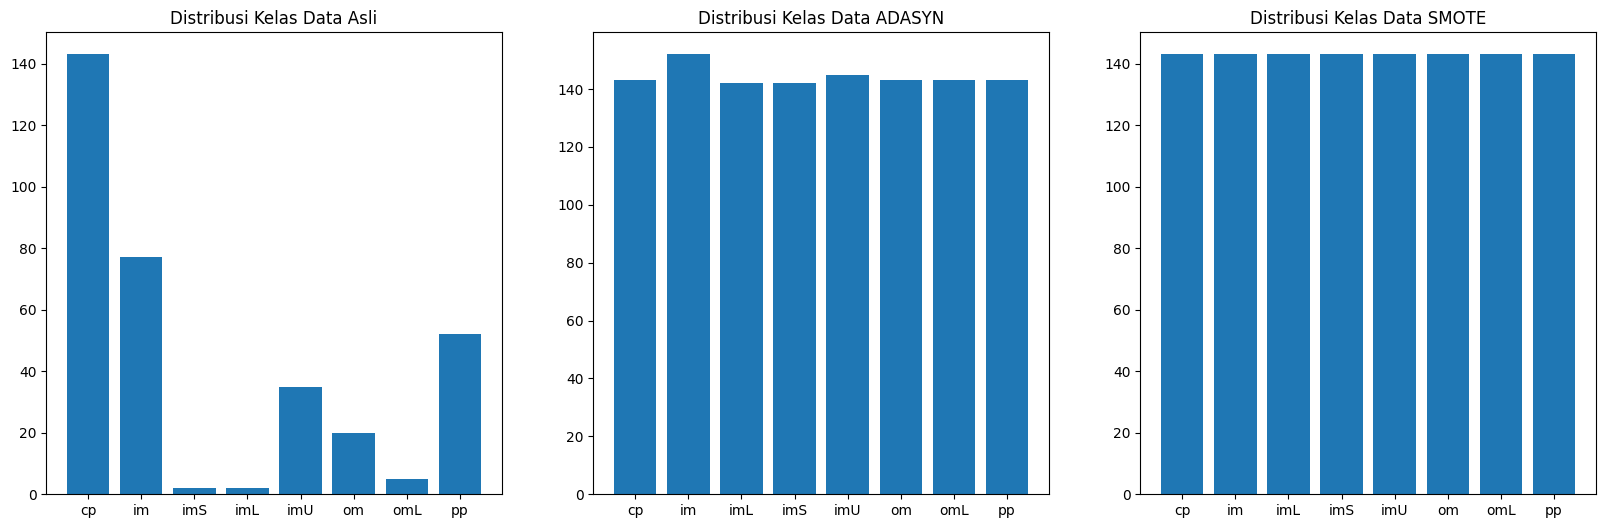

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(20,6))

axs[0].set_title("Distribusi Kelas Data Asli")
axs[0].bar(class_ecoli, distributed_data)

axs[1].set_title("Distribusi Kelas Data ADASYN")
axs[1].bar(kelas, dist_data)


axs[2].set_title("Distribusi Kelas Data SMOTE")
axs[2].bar(kelas_smote, dist_smote)

plt.show()